# Proyecto End-to-End: Predicción de Fuga de Clientes (Churn) en Telecomunicaciones

## Definición del Problema de Negocio
**Contexto:**
En la industria de las telecomunicaciones, retener a un cliente es significativamente más barato que adquirir uno nuevo. La "fuga de clientes" (Churn) representa una pérdida directa de ingresos recurrentes.

**Objetivo:**
Desarrollar un modelo de Machine Learning capaz de predecir la probabilidad de que un cliente abandone la compañía.

**Impacto Esperado:**
Identificar a los clientes en riesgo permitirá al equipo de marketing desplegar campañas de retención preventivas (descuentos, ofertas personalizadas), reduciendo la tasa de cancelación y protegiendo el *Revenue* de la empresa.

**Dataset:**
Utilizaremos datos demográficos, de servicios contratados y facturación.

In [7]:
# Importación de librerías esenciales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Configuración visual para que los gráficos se vean profesionales
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
warnings.filterwarnings('ignore') # Omitir warnings molestos para la presentación

# Cargar el dataset
# Asegúrate de que el archivo esté en la carpeta 'data'
df = pd.read_csv('../data/telco_churn.csv')

# Vista preliminar
print(f"Dimensiones del dataset: {df.shape}")
df.head()

Dimensiones del dataset: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Comprensión y Limpieza de Datos
Antes de visualizar, debemos asegurar la calidad de los datos. Revisaremos tipos de datos y valores nulos.

In [8]:
df.info()

# OBSERVACIÓN IMPORTANTE:
# 'TotalCharges' aparece como objeto (texto), pero debería ser numérico.
# Esto suele pasar cuando hay espacios vacíos (" ") en lugar de nulos reales.

# Conversión a numérico, forzando los errores a NaN (Not a Number)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Verificar cuántos nulos se generaron
nulls = df.isnull().sum()
print(f"\nValores nulos encontrados tras la conversión:\n{nulls[nulls > 0]}")

# Decisión de limpieza:
# Como son muy pocos registros (generalmente < 15 en este dataset), los eliminaremos.
df.dropna(inplace=True)

# Eliminar columna customerID ya que no aporta valor predictivo
df.drop(columns=['customerID'], inplace=True)

print("\nDatos limpios y listos para análisis.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## Análisis Exploratorio de Datos (EDA)

### Variable Objetivo: Churn
¿Qué tan balanceado está el problema? Si tenemos muy pocos casos de fuga, el modelo podría tener dificultades para aprender.

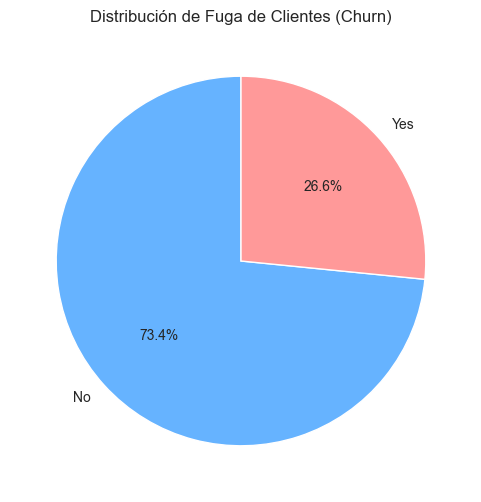

INSIGHT: El dataset está desbalanceado. Solo el ~26% de los clientes se han ido.
Esto implica que al modelar, deberemos tener cuidado con la métrica de 'Accuracy'.
Será mejor usar Recall o F1-Score para medir qué tan bien detectamos a los que se van.


In [ ]:
# Conteo de valores
churn_counts = df['Churn'].value_counts()

# Gráfico
plt.figure(figsize=(6,6))
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', colors=['#66b3ff','#ff9999'], startangle=90)
plt.title('Distribución de Fuga de Clientes (Churn)')
plt.show()

# Insight de Negocio
print("INSIGHT: El dataset está desbalanceado. Solo el ~26% de los clientes se han ido.")
print("Esto implica que al modelar, deberemos tener cuidado con la métrica de 'Accuracy'.")
print("Será mejor usar Recall o F1-Score para medir qué tan bien detectamos a los que se van.")

### Variables Numéricas: ¿El dinero y el tiempo influyen?
Analizaremos `MonthlyCharges` (pago mensual) y `Tenure` (meses de permanencia) respecto al Churn.

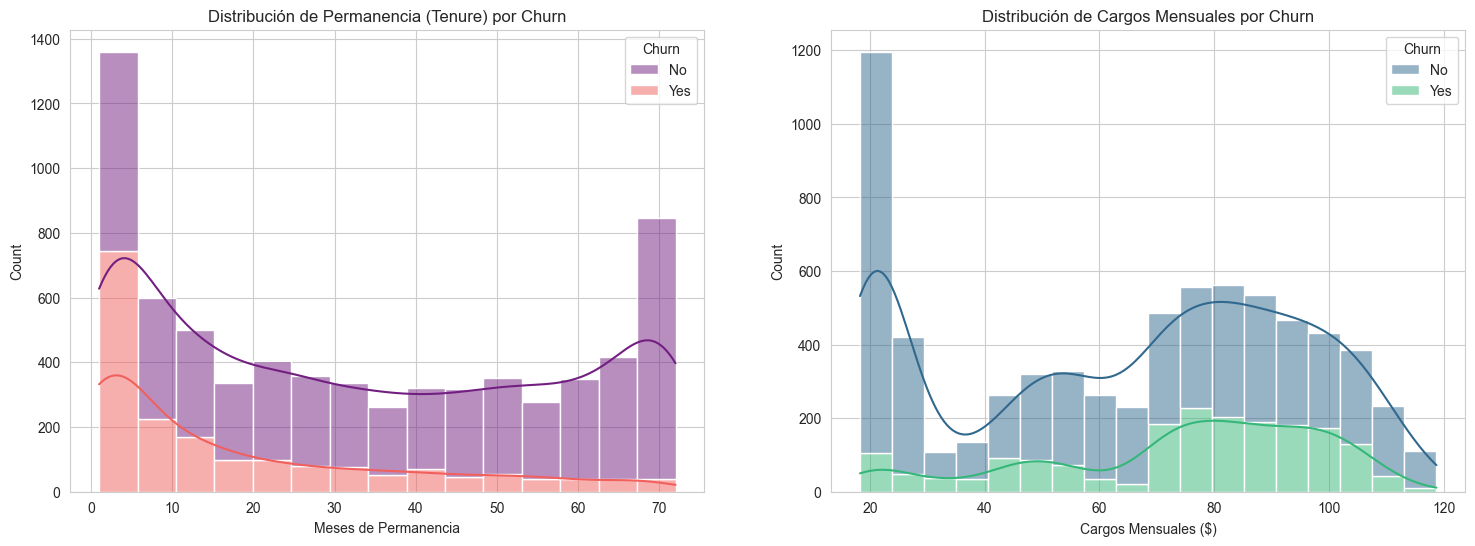

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Distribución de la permanencia (Tenure)
sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack', kde=True, palette='magma', ax=ax[0])
ax[0].set_title('Distribución de Permanencia (Tenure) por Churn')
ax[0].set_xlabel('Meses de Permanencia')

# Distribución de cargos mensuales
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', multiple='stack', kde=True, palette='viridis', ax=ax[1])
ax[1].set_title('Distribución de Cargos Mensuales por Churn')
ax[1].set_xlabel('Cargos Mensuales ($)')

plt.show()

**Insights Clave:**
1. **Fuga temprana:** La mayor cantidad de abandonos ocurre en los primeros meses (Tenure bajo). Los clientes nuevos son los más vulnerables.
2. **Sensibilidad al precio:** Los clientes con cargos mensuales altos ($70-$100) tienden a irse más que los que pagan poco.

### Variables Categóricas: Contratos y Servicios
¿Cómo influye el tipo de contrato o el método de pago?

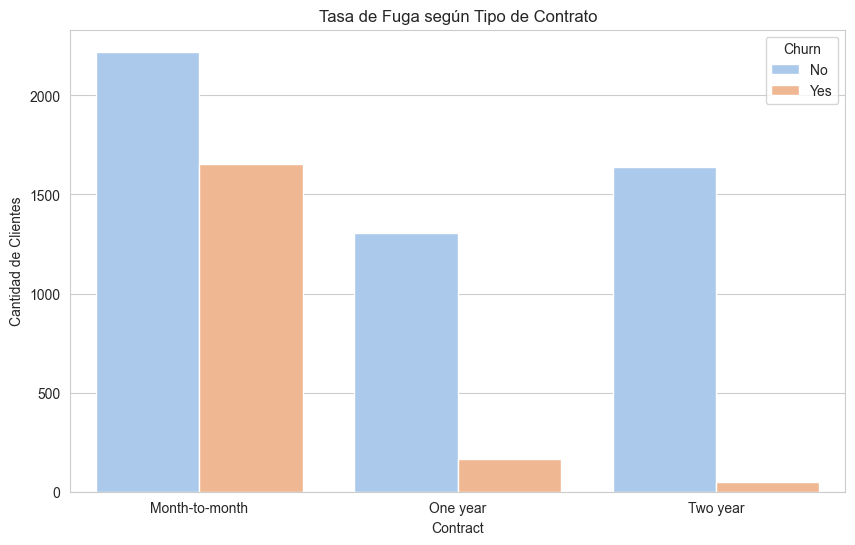

Churn                  No        Yes
Contract                            
Month-to-month  57.290323  42.709677
One year        88.722826  11.277174
Two year        97.151335   2.848665


In [11]:
# que tipo de contrato es mas peligroso?
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Contract', hue='Churn', palette='pastel')
plt.title('Tasa de Fuga según Tipo de Contrato')
plt.ylabel('Cantidad de Clientes')
plt.show()

# Tabla de contingencia para ver porcentajes exactos
contract_churn = pd.crosstab(df['Contract'], df['Churn'], normalize='index') * 100
print(contract_churn)

## Conclusiones del EDA y Siguientes Pasos

Tras el análisis, hemos detectado patrones claros:
1. **Factor Contrato:** Los clientes con contrato "Month-to-month" tienen una tasa de fuga alarmante en comparación con los de 1 o 2 años.
2. **Factor Antigüedad:** El riesgo es crítico en los primeros 6 meses de vida del cliente.
3. **Factor Precio:** Clientes con facturas altas y servicios de fibra óptica (verificado en análisis suplementario) tienden a rotar más.

**Estrategia de Modelado:**
* Necesitaremos codificar las variables categóricas (One-Hot Encoding).
* Escalaremos las variables numéricas (`Tenure`, `MonthlyCharges`) para que modelos como Regresión Logística o SVM funcionen bien.
* Probaremos modelos base: Regresión Logística, Random Forest y XGBoost.

# Preprocesamiento e Ingeniería de Características

**Objetivo:** Transformar los datos crudos (limpios) en un formato matemático digerible para los algoritmos de Machine Learning.

**Pasos:**
1. Convertir variables categóricas a numéricas (Encoding).
2. Escalar variables numéricas para evitar sesgos por magnitud.
3. Dividir el dataset en Entrenamiento (Train) y Prueba (Test).

Una vez entendidos los datos, preparamos el dataset para el entrenamiento.
Pasos:
1. **Encoding:** Convertir variables categóricas a numéricas.
2. **Split:** Dividir en entrenamiento y prueba.
3. **Scaling:** Escalar variables numéricas.

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. One-Hot Encoding
# Convertimos todas las categóricas a variables dummy (0 y 1)
df_clean = pd.get_dummies(df, drop_first=True)

# 2. Definir X e y
# 'Churn_Yes' es la columna que se generó al convertir 'Churn'. 1 = Se fue, 0 = Se quedó.
X = df_clean.drop('Churn_Yes', axis=1)
y = df_clean['Churn_Yes']

# 3. División Stratificada (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Escalado (Scaling)
# Es importante escalar SOLO con fit sobre el train set para evitar Data Leakage
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertimos de nuevo a DataFrame para no perder los nombres de las columnas
X_train_final = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_final = pd.DataFrame(X_test_scaled, columns=X.columns)

print("Datos listos para modelar.")
print(f"Shape X_train: {X_train_final.shape}")

Datos listos para modelar.
Shape X_train: (5625, 30)


---
## 6. Modelado y Evaluación

Probaremos dos algoritmos:
1. **Regresión Logística:** Nuestro modelo base (Baseline). Es interpretable y nos dice *qué variables* pesan más.
2. **Random Forest:** Un modelo de ensamble más robusto que suele capturar relaciones no lineales.

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- Modelo 1: Regresión Logística ---
log_model = LogisticRegression(random_state=42)
log_model.fit(X_train_final, y_train)
y_pred_log = log_model.predict(X_test_final)

# --- Modelo 2: Random Forest ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_final, y_train)
y_pred_rf = rf_model.predict(X_test_final)

print("Modelos entrenados correctamente.")

Modelos entrenados correctamente.


### Evaluación del Desempeño
Dado que el dataset está desbalanceado (menos gente se va de la que se queda), el **Accuracy** puede ser engañoso.

Nos enfocaremos en el **Recall (Sensibilidad)** para la clase 1 (Churn):
* *¿De todos los que realmente se iban a ir, a cuántos detectamos?*
Es preferible detectar falsos positivos (pensar que alguien se va y que no se vaya) a dejar escapar a alguien que sí se va.

--- Resultados para Regresión Logística ---
              precision    recall  f1-score   support

       False       0.85      0.89      0.87      1033
        True       0.65      0.57      0.61       374

    accuracy                           0.80      1407
   macro avg       0.75      0.73      0.74      1407
weighted avg       0.80      0.80      0.80      1407



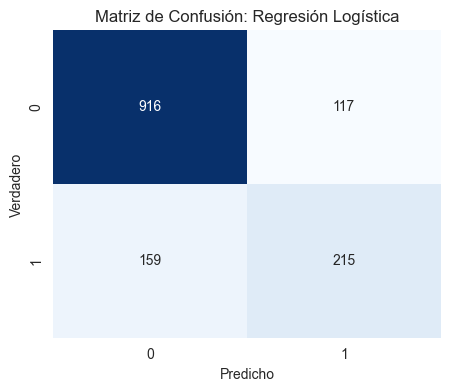

--- Resultados para Random Forest ---
              precision    recall  f1-score   support

       False       0.83      0.89      0.86      1033
        True       0.62      0.51      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



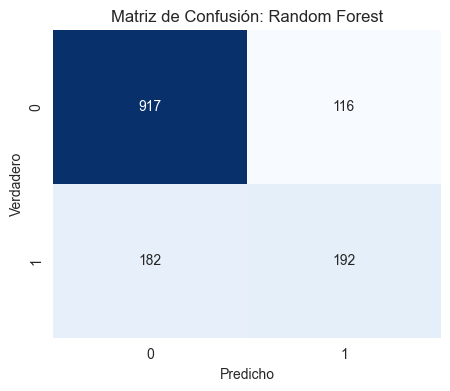

In [14]:
# creamos una funcion para mostrar resultados del desempeño
def mostrar_resultados(y_test, y_pred, modelo_nombre):
    print(f"--- Resultados para {modelo_nombre} ---")
    print(classification_report(y_test, y_pred))
    
    # Matriz de Confusión Gráfica
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriz de Confusión: {modelo_nombre}')
    plt.ylabel('Verdadero')
    plt.xlabel('Predicho')
    plt.show()

# Mostrar Logística
mostrar_resultados(y_test, y_pred_log, "Regresión Logística")

# Mostrar Random Forest
mostrar_resultados(y_test, y_pred_rf, "Random Forest")

### 6.2 Interpretabilidad: ¿Qué variables son más importantes?
Analizamos qué factores pesan más en la decisión del modelo.

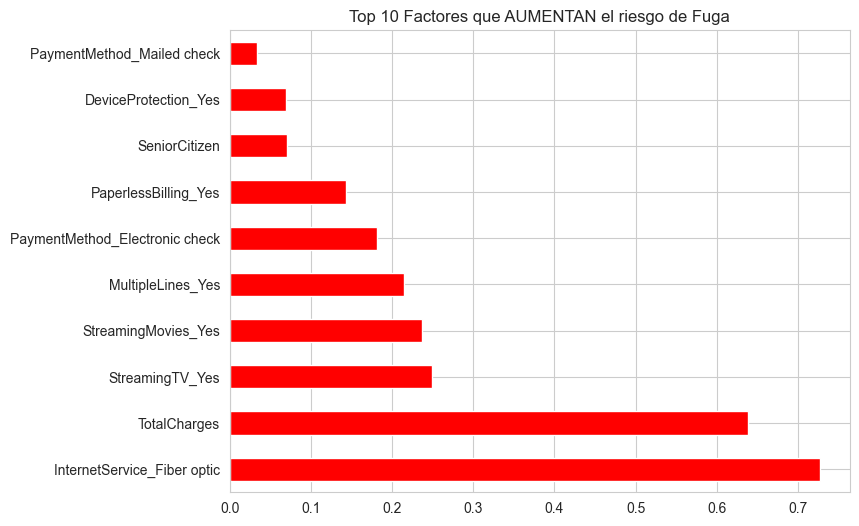

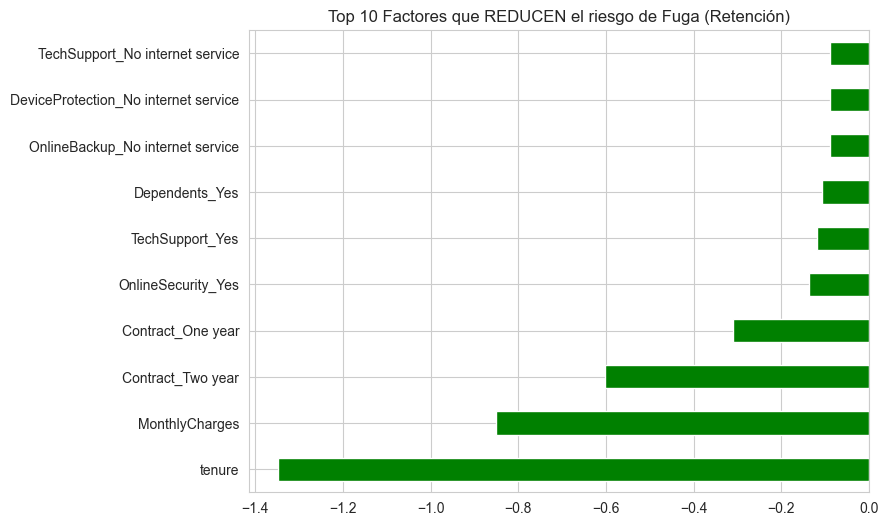

In [15]:
# Usaremos los pesos de la Regresión Logística porque nos dice si la relación es positiva (aumenta el riesgo) o negativa (reduce el riesgo).
weights = pd.Series(log_model.coef_[0], index=X.columns.values)
plt.figure(figsize=(8,6))
weights.sort_values(ascending=False)[:10].plot(kind='barh', color='red') # Top 10 factores de riesgo
plt.title('Top 10 Factores que AUMENTAN el riesgo de Fuga')
plt.show()

plt.figure(figsize=(8,6))
weights.sort_values(ascending=True)[:10].plot(kind='barh', color='green') # Top 10 factores de retención
plt.title('Top 10 Factores que REDUCEN el riesgo de Fuga (Retención)')
plt.show()


## Conclusión de Negocio y Recomendaciones

### Hallazgos Principales:
1. **Fibra Óptica:** Los clientes con servicio de Fibra Óptica son los más propensos a irse. *Acción recomendada:* Revisar la calidad técnica del servicio de fibra o el precio en comparación con la competencia.
2. **Contratos Mensuales:** La flexibilidad juega en contra. Los contratos mes a mes tienen altísimo riesgo. *Acción recomendada:* Ofrecer incentivos (descuentos) para migrar a contratos de 1 año.
3. **Nuevos Clientes:** El riesgo es máximo en los primeros meses. *Acción recomendada:* Programa de "Onboarding" agresivo para nuevos usuarios.

### Próximos Pasos (Next Steps):
* **Mejora del Modelo:** Probar técnicas de balanceo como SMOTE para mejorar la detección de fugas (aumentar el Recall).
* **Despliegue:** Implementar este modelo en una API (FastAPI) para que el sistema de CRM consulte en tiempo real la probabilidad de fuga de un cliente.